In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

# Función para cargar las imágenes de los espectrogramas
def cargar_espectrogramas_y_etiquetas(csv_path):
    df = pd.read_csv(csv_path)
    rutas = df['Ruta espectrograma'].values
    etiquetas = df['Etiqueta'].values

    # Cargar imágenes y etiquetas
    espectrogramas = []
    for ruta in rutas:
        img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)  # Leer en escala de grises
        img = cv2.resize(img, (128, 128))  # Redimensionar para uniformidad
        espectrogramas.append(img)
        #vamos a ver las imagenes
        #img_array = np.array(img)
        #plt.imshow(img_array, cmap='gray')
        #plt.title(f'Etiqueta: {etiquetas[0]} , nombre {ruta}')
        #plt.show()
    # Convertir a arrays y normalizar
    espectrogramas = np.array(espectrogramas) / 255.0  # Normalización
    etiquetas = np.array(etiquetas)

    return espectrogramas, etiquetas, rutas

# Cargar datos de ambos CSV
espectrogramas_IA, etiquetas_IA, rutas_IA = cargar_espectrogramas_y_etiquetas('/content/drive/MyDrive/Proyecto SIC/datos_espectrogramas_IA.csv')
espectrogramas_reales, etiquetas_reales, rutas_reales = cargar_espectrogramas_y_etiquetas('/content/drive/MyDrive/Proyecto SIC/datos_espectrogramas_reales.csv')

# Concatenar ambos conjuntos de datos
X = np.concatenate([espectrogramas_IA, espectrogramas_reales], axis=0)
y = np.concatenate([etiquetas_IA, etiquetas_reales], axis=0)
rutas_espectrogramas = np.concatenate([rutas_IA, rutas_reales], axis=0)

# Agregar dimensión para canales (compatibilidad con Keras)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Forma: (n_samples, altura, ancho, canales)

# Dividir en conjuntos de entrenamiento y prueba, manteniendo las rutas de los archivos en X_test
X_train, X_test, y_train, y_test, rutas_train, rutas_test = train_test_split(
    X, y, rutas_espectrogramas, test_size=0.2, random_state=42
)

# Convertir etiquetas a formato categórico
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, LSTM, Dense, Input
from tensorflow.keras.layers import GlobalAveragePooling2D

# Crear el modelo
model = Sequential()

# Parte CNN: 4 capas convolucionales
model.add(Input(shape=(128, 128, 1)))  # Definir la entrada explícitamente
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Aplanar
model.add(Flatten())

# Calcular automáticamente la nueva forma
# Dividiremos los 9216 elementos en 64 secuencias
model.add(Reshape((64, 9216 // 64)))  # Salida será (batch_size, 64, 144)

# Parte RNN: LSTM
model.add(LSTM(128, return_sequences=False))  # Una capa LSTM
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(2, activation='softmax'))  # Dos clases: voces reales (1) vs IA (0)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 64, 144)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │         139,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 527,874 (2.01 MB)

 Trainable params: 527,874 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(X_train, y_train, epochs=45, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6289 - loss: 0.6664 - val_accuracy: 0.6474 - val_loss: 0.6725
Epoch 2/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6269 - loss: 0.6689 - val_accuracy: 0.6474 - val_loss: 0.6576
Epoch 3/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6068 - loss: 0.6725 - val_accuracy: 0.6474 - val_loss: 0.6453
Epoch 4/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6247 - loss: 0.6527 - val_accuracy: 0.6579 - val_loss: 0.6220
Epoch 5/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7134 - loss: 0.5849 - val_accuracy: 0.8000 - val_loss: 0.4946
Epoch 6/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8132 - loss: 0.4993 - val_accuracy: 0.8421 - val_loss: 0.4443
Epoch 7/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8178 - loss: 0.4655 - val_accuracy: 0.8316 - val_loss: 0.4538
Epoch 8/45
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8156 - loss: 0.4863 - val_accuracy: 0.8368 - v

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc * 100:.2f}%")
print(f"Pérdida en el conjunto de prueba: {test_loss * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9620 - loss: 0.1547
Precisión en el conjunto de prueba: 97.37%
Pérdida en el conjunto de prueba: 10.47%


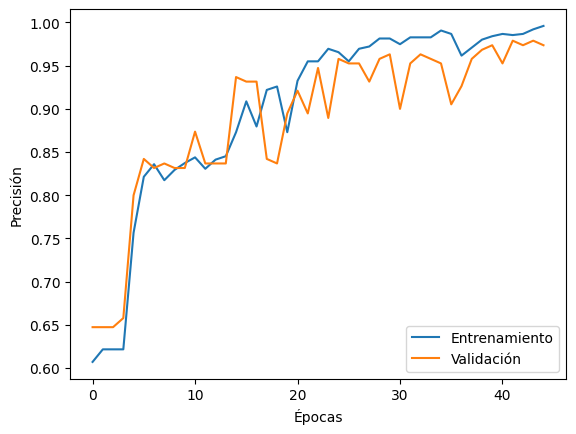

In [ ]:
import matplotlib.pyplot as plt
# Gráfica de la precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()


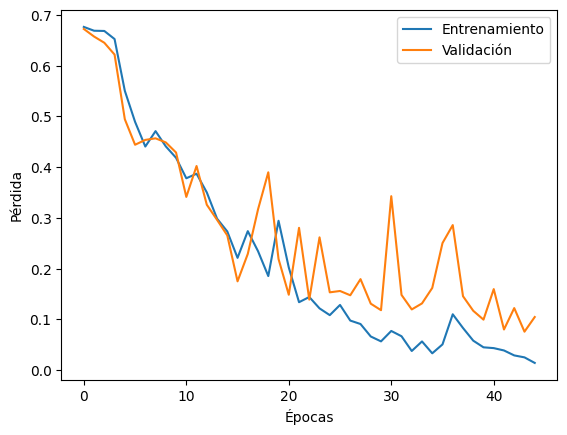

In [ ]:
# Gráfica de la pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.show()

In [ ]:
import numpy as np

# Realizar predicciones con el conjunto de prueba
predicciones = model.predict(X_test)

# Convertir las predicciones de probabilidades a etiquetas (0, 1)
predicciones_clases = np.argmax(predicciones, axis=1)

# Convertir etiquetas verdaderas para comparación (si están en formato one-hot)
y_test_clases = np.argmax(y_test, axis=1)

# Mostrar las primeras 50 predicciones con rutas y niveles de confianza
print("Predicciones de las primeras 50 muestras:\n")
for i in range(min(100, len(X_test))):
    ruta_archivo = rutas_test[i]  # Usar las rutas generadas o reales
    prediccion = predicciones_clases[i]
    confianza = predicciones[i][prediccion] * 100

    # Mostrar ubicación, predicción en términos de clase y confianza
    print(f"Ubicación en Drive: {ruta_archivo}")
    print(f"Predicción del modelo: Clase {prediccion} ({confianza:.2f}% de confianza)")
    print(f"Etiqueta verdadera: Clase {y_test_clases[i]}\n")

# Evaluar el modelo en el conjunto de prueba
print("Evaluando el modelo en el conjunto de prueba...\n")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Pérdida en el conjunto de prueba: {test_loss *100:.4f}%")
print(f"Precisión en el conjunto de prueba: {test_acc * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicciones de las primeras 50 muestras:

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_IA/clip_b37e7deb-4b86-4a3a-8ce3-c2b156766387.png
Predicción del modelo: Clase 1 (99.46% de confianza)
Etiqueta verdadera: Clase 0

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_IA/clip_26.png
Predicción del modelo: Clase 0 (96.59% de confianza)
Etiqueta verdadera: Clase 0

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_reales/clip_a3338b0c-7e60-412e-a517-57990c475891.png
Predicción del modelo: Clase 1 (99.84% de confianza)
Etiqueta verdadera: Clase 1

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_reales/clip_51.png
Predicción del modelo: Clase 1 (99.98% de confianza)
Etiqueta verdadera: Clase 1

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_IA/clip_72.png
Predicción del modelo: Clase 0 (99.99% de confianza)
Etiqueta verdadera: Clase 0

Ubi

In [ ]:
# Realizar predicciones con el conjunto de prueba
predicciones = model.predict(X_test)

# Convertir las predicciones de probabilidades a etiquetas (0, 1)
predicciones_clases = np.argmax(predicciones, axis=1)

# Convertir etiquetas verdaderas para comparación (si están en formato one-hot)
y_test_clases = np.argmax(y_test, axis=1)

# Mostrar las primeras 50 predicciones con rutas y niveles de confianza
print("Predicciones de las primeras 50 muestras:\n")
for i in range(min(50, len(X_test))):
    ruta_archivo = rutas_test[i]  # Usar rutas reales cargadas desde los datos
    prediccion = predicciones_clases[i]
    confianza = predicciones[i][prediccion] * 100

    # Mostrar ubicación, predicción en términos de clase y confianza
    print(f"Ubicación en Drive: {ruta_archivo}")
    print(f"Predicción del modelo: Clase {prediccion} ({confianza:.2f}% de confianza)")
    print(f"Etiqueta verdadera: Clase {y_test_clases[i]}\n")

# Evaluar el modelo en el conjunto de prueba
print("Evaluando el modelo en el conjunto de prueba...\n")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Pérdida en el conjunto de prueba: {test_loss * 100:.4f}%")
print(f"Precisión en el conjunto de prueba: {test_acc * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step
Predicciones de las primeras 50 muestras:

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_IA/clip_b37e7deb-4b86-4a3a-8ce3-c2b156766387.png
Predicción del modelo: Clase 1 (91.95% de confianza)
Etiqueta verdadera: Clase 0

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_IA/clip_26.png
Predicción del modelo: Clase 0 (99.13% de confianza)
Etiqueta verdadera: Clase 0

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_reales/clip_a3338b0c-7e60-412e-a517-57990c475891.png
Predicción del modelo: Clase 1 (66.65% de confianza)
Etiqueta verdadera: Clase 1

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_reales/clip_51.png
Predicción del modelo: Clase 1 (99.91% de confianza)
Etiqueta verdadera: Clase 1

Ubicación en Drive: /content/drive/MyDrive/Proyecto SIC/espectrogramas_IA/clip_72.png
Predicción del modelo: Clase 0 (100.00% de confianza)
Etiqueta verdadera: Clase 0

U

In [ ]:
from tensorflow.keras.models import load_model

# Ruta donde guardar el modelo en tu Drive
ruta_modelo = '/content/drive/MyDrive/Proyecto SIC/modelo_RNN_CNN_DetectVoice_00.h5'

# Guardar el modelo en formato HDF5
model.save(ruta_modelo)
print(f"Modelo guardado en: {ruta_modelo}")

Modelo guardado en: /content/drive/MyDrive/Proyecto SIC/modelo_RNN_CNN_DetectVoice_00.h5
